### Feedforward Neural Network on the Iris Dataset
Using Pipeline API

In [1]:
#import packages
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt 
#BigDL packages
from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *
from bigdl.models.ml_pipeline.dl_classifier import *

from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, udf
from pyspark.ml import  Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
#Creating spark context 
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","8g"))

init_engine()

/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7/, and pyspark is found in: /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


In [2]:
#Setting the path for Spark
os.environ['JAVA_HOME']="/usr/lib/jvm/java-8-oracle"
os.environ['SPARK_HOME'] = "/home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/kunal/Downloads/jarfiles/bigdl-SPARK_2.2-0.7.0-jar-with-dependencies.jar --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.3 pyspark-shell'

In [4]:
#Creating Spark Session
from pyspark.context import SparkContext
# from pyspark.sql.session import SparkSession
#import pyspark packages
## Create SparkContext, SparkSession
import pyspark
from pyspark.conf import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.sql import SQLContext
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [5]:
#parameters
learning_rate = 0.1
training_epochs = 100
batch_size = 16
display_step = 1

# Network Parameters
n_input = 4
n_classes = 3
n_hidden = 3 # 1st layer number of features

In [6]:
# Number of hidden layers
n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))
#Hidden Layers
n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))

Hidden layer 1 (Guess) : 2.5021971019484877
Hidden layer 2 (Guess) : 2.6832815729997477


In [7]:
#Loading data
# iris_training = spark.read.csv("file:///../data/iris/iris_training.csv", header=True, inferSchema="true")
iris_training_pandas = pd.read_csv("./data/iris_training.csv")

In [8]:
# iris_test = spark.read.csv("/home/kunal/Documents/hadoop_spark_example/notebook_pyspark/BigDL-trainings/elephantscale/data/iris/iris_test.csv", header=True, inferSchema="true")
iris_test_pandas = pd.read_csv("./data/iris_test.csv")

In [9]:
#Method to convert from pandas dataframe to Spark data frame
# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)
# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
          struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlContext.createDataFrame(pandas_df, p_schema)

In [10]:
iris_training=pandas_to_spark(iris_training_pandas)
iris_test=pandas_to_spark(iris_test_pandas)

In [11]:
iris_training = iris_training.select([col(c).cast("double") for c in iris_training.columns])
iris_test = iris_test.select([col(c).cast("double") for c in iris_test.columns])

In [12]:
#Spark MLlib pipeline
assembler =  VectorAssembler(inputCols=['c1','c2','c3','c4'], outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")
pipeline = Pipeline(stages = [assembler, scaler])
pipelineTraining = pipeline.fit(iris_training)
iris_data_training = pipelineTraining.transform(iris_training)
pipelineTest = pipeline.fit(iris_test)
iris_data_test = pipelineTraining.transform(iris_test)

In [13]:
iris_data_training.select('features', 'label').show(10, False)

+----------------------------------------------------------------------------+-----+
|features                                                                    |label|
+----------------------------------------------------------------------------+-----+
|[7.368361487942233,6.554983225240457,3.0733762260577677,2.8131580240711687] |3.0  |
|[5.756532326675853,5.384450486513465,1.811096709314335,1.278708165044369]   |2.0  |
|[5.641401789939477,5.8526636936349625,2.4696773665690612,2.173803941548984] |3.0  |
|[5.641401789939477,7.257302756845952,0.8232257888563537,0.12787081840986056]|1.0  |
|[6.562446632816191,8.896048702694443,0.9329892535401773,0.3836124647566999] |1.0  |
|[5.065748557271891,7.491409639483454,0.7134623241725301,0.2557416368197211] |1.0  |
|[6.217055022607061,7.959622846604952,0.8232257888563537,0.5114832736394422] |1.0  |
|[7.944014720609817,7.257302756845952,2.7989676297723163,2.941028718628492]  |3.0  |
|[7.713753098151361,7.257302756845952,2.4147956996512567,1.790191

In [14]:
#Pipeline API to set up neural network classifier
bigDLModel = Sequential().add(Linear(n_input, n_hidden)).add(Linear(n_hidden, n_classes)).add(LogSoftMax())
classnll_criterion = ClassNLLCriterion()
dlClassifier = DLClassifier(model=bigDLModel, criterion=classnll_criterion, feature_size=[n_input])
dlClassifier.setLabelCol("label").setMaxEpoch(training_epochs).setBatchSize(16).setLearningRate(learning_rate)
model = dlClassifier.fit(iris_data_training)
print("\ninitial model training finished.")

creating: createSequential
creating: createLinear
creating: createLinear
creating: createLogSoftMax
creating: createClassNLLCriterion
creating: createDLClassifier

initial model training finished.


In [15]:
#Model Transform
predictionDF=model.transform(iris_data_test)

In [17]:
#help
help(predictionDF)

Help on DataFrame in module pyspark.sql.dataframe object:

class DataFrame(builtins.object)
 |  A distributed collection of data grouped into named columns.
 |  
 |  A :class:`DataFrame` is equivalent to a relational table in Spark SQL,
 |  and can be created using various functions in :class:`SparkSession`::
 |  
 |      people = spark.read.parquet("...")
 |  
 |  Once created, it can be manipulated using the various domain-specific-language
 |  (DSL) functions defined in: :class:`DataFrame`, :class:`Column`.
 |  
 |  To select a column from the data frame, use the apply method::
 |  
 |      ageCol = people.age
 |  
 |  A more concrete example::
 |  
 |      # To create DataFrame using SparkSession
 |      people = spark.read.parquet("...")
 |      department = spark.read.parquet("...")
 |  
 |      people.filter(people.age > 30).join(department, people.deptId == department.id) \
 |        .groupBy(department.name, "gender").agg({"salary": "avg", "age": "max"})
 |  
 |  .. versionadd

In [18]:
#Show top 20 rows
predictionDF.show()

+-----------------+------------------+------------------+-------------------+-----+--------------------+--------------------+----------+
|               c1|                c2|                c3|                 c4|label|           assembled|            features|prediction|
+-----------------+------------------+------------------+-------------------+-----+--------------------+--------------------+----------+
|5.900000095367432|               3.0| 4.199999809265137|                1.5|  2.0|[5.90000009536743...|[6.79270825527464...|       2.0|
|6.900000095367432|3.0999999046325684| 5.400000095367432| 2.0999999046325684|  3.0|[6.90000009536743...|[7.94401472060981...|       3.0|
|5.099999904632568| 3.299999952316284|1.7000000476837158|                0.5|  1.0|[5.09999990463256...|[5.87166286341222...|       1.0|
|              6.0|3.4000000953674316|               4.5|  1.600000023841858|  2.0|[6.0,3.4000000953...|[6.90783879201102...|       2.0|
|              5.5|               2.5|   

In [19]:
# Coerce the outpu to be a Dataframe object -- return object is a JavaObject by defaul.
# from pyspark.sql import DataFrame, SQLContext
# predictionDF = DataFrame(model.transform(iris_data_test), SQLContext(sc))

In [20]:
#Model Evolution
predictionDF.cache()
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
auPRC = evaluator.evaluate(predictionDF)
print("\nArea under precision-recall curve: = " + str(auPRC))
    
recall = MulticlassClassificationEvaluator(metricName="weightedRecall").evaluate(predictionDF)
print("\nrecall = " + str(recall))

precision = MulticlassClassificationEvaluator(metricName="weightedPrecision").evaluate(predictionDF)
print("\nPrecision = " + str(precision))
predictionDF.unpersist()


Area under precision-recall curve: = 1.0

recall = 0.9333333333333333

Precision = 0.9333333333333333


DataFrame[c1: double, c2: double, c3: double, c4: double, label: double, assembled: vector, features: vector, prediction: double]

In [21]:
#Accuracy and Confusion Matrix
y_pred = np.array(predictionDF.select('prediction').collect())
y_true = np.array(predictionDF.select('label').collect())

The prediction accuracy is 93.33%


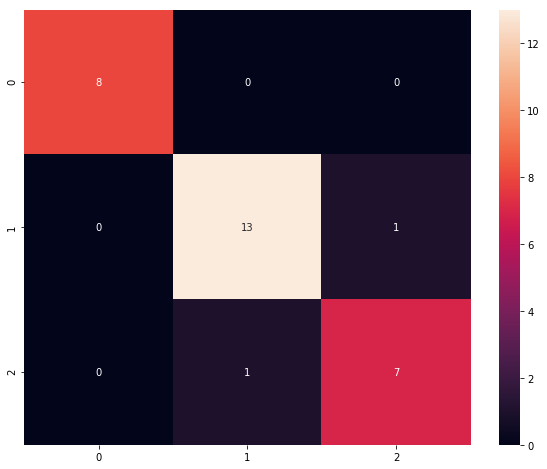

In [22]:
#prediction accuracy
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');